In [23]:
import tensorflow_data_validation as tfdv

from aif360.datasets import StandardDataset
import numpy as np
import pandas as pd
import experiment_util as util
import models
import random

%matplotlib ipympl
%matplotlib inline

import matplotlib.pyplot as plt
import plot_util as putil
import numpy as np

np.random.seed(0)
random.seed(0)

Load datasets, modify it for the experiment and use Framework to examine the dataset.

In [2]:
raw_df=pd.read_csv("../Datasets/Kaggle/Job Application/data.csv",index_col=0)

In [7]:
df=raw_df.copy()

In [4]:
stats = tfdv.generate_statistics_from_dataframe(df)
tfdv.visualize_statistics(stats)

Tensorflow Data Validation has flag **Employment** and **Employed** feature as feature with significant amount of missing value. However, they are transformed categorical feature which is fine with having huge amounts of 0

The **HaveWorkedWith** contains codebase that the applicants have worked with. However, its too varied and hard to work with scikit-learn and AI Fariness 360, so this feature is ignored in traning.

In [10]:
df=df.drop(["HaveWorkedWith"],axis=1)
df=df.dropna()

In [12]:
folds_index=np.array_split(df.sample(frac=1).index,5)
eval=util.evaluation(df,"Gender","Employed","Man",folds_index)
result=pd.DataFrame([],columns=util.column)
result.columns.name="Job"
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference


Scikit-learn data preprocessing

In [13]:
numeric_feautre_names=df.select_dtypes(include=["number"]).columns
categorical_feature_names=df.select_dtypes(include=["object_"]).columns

pre_df=df.copy()

for nc in numeric_feautre_names:
    pre_df[nc]=util.min_max_noramlize(pre_df[nc])   

for cc in categorical_feature_names:
    pre_df[cc]=pd.factorize(pre_df[cc])[0]

In [14]:
result=util.append_Series(result,eval.cross_validation("Random Forest",models.RandomForest,pre_df))
result

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761


In [15]:
result=util.append_Series(result,eval.cross_validation("Neural Network",models.NeuralNetwork,pre_df))
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761
Neural Network,-0.027490,0.289513,-0.169357,0.169357,-0.289513,0.234343,-0.234343,0.034513,-0.031745,-0.034513,0.169357,0.599071


In [16]:
result=util.append_Series(result,eval.cross_validation("Gradient Boosting",models.GradientBoost,pre_df))
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761
Neural Network,-0.027490,0.289513,-0.169357,0.169357,-0.289513,0.234343,-0.234343,0.034513,-0.031745,-0.034513,0.169357,0.599071
Gradient Boosting,-0.019884,0.034069,0.009499,-0.009499,-0.034069,0.032760,-0.032760,-0.001380,0.041708,0.001380,-0.009499,0.786883


Scikit-learn models with DisparateImpactRemover from AIF360 preprocessing

In [17]:
raw_dataset=StandardDataset(df=df, label_name="Employed",
                                    favorable_classes=[1],
                                    scores_name="",
                                    protected_attribute_names=['Gender'],
                                    privileged_classes=[["Man"]],
                                    categorical_features=['Age','Accessibility','EdLevel','MentalHealth', 'MainBranch',"Country"])

In [18]:
result=util.append_Series(result,eval.cross_validation("Random Forest (DI)",models.DI_RandomForest,raw_dataset))
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761
Neural Network,-0.027490,0.289513,-0.169357,0.169357,-0.289513,0.234343,-0.234343,0.034513,-0.031745,-0.034513,0.169357,0.599071
Gradient Boosting,-0.019884,0.034069,0.009499,-0.009499,-0.034069,0.032760,-0.032760,-0.001380,0.041708,0.001380,-0.009499,0.786883
Random Forest (DI),-0.026847,-0.050141,0.098397,-0.098397,0.050141,-0.055091,0.055091,-0.042111,0.098944,0.042111,-0.098397,0.762136


In [19]:
result=util.append_Series(result,eval.cross_validation("Neural Network (DI)",models.DI_NeuralNetwork,raw_dataset))
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761
Neural Network,-0.027490,0.289513,-0.169357,0.169357,-0.289513,0.234343,-0.234343,0.034513,-0.031745,-0.034513,0.169357,0.599071
Gradient Boosting,-0.019884,0.034069,0.009499,-0.009499,-0.034069,0.032760,-0.032760,-0.001380,0.041708,0.001380,-0.009499,0.786883
Random Forest (DI),-0.026847,-0.050141,0.098397,-0.098397,0.050141,-0.055091,0.055091,-0.042111,0.098944,0.042111,-0.098397,0.762136
Neural Network (DI),0.038151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.038151,NaN,0.038151,0.000000,0.536223


The framework output NaN is due to the Neural Network model with Disparate Impact Remover preprocessing will only output Negative predictions.

In [20]:
result=util.append_Series(result,eval.cross_validation("Gradient Boosting (DI)",models.DI_GradientBoost,raw_dataset))
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761
Neural Network,-0.027490,0.289513,-0.169357,0.169357,-0.289513,0.234343,-0.234343,0.034513,-0.031745,-0.034513,0.169357,0.599071
Gradient Boosting,-0.019884,0.034069,0.009499,-0.009499,-0.034069,0.032760,-0.032760,-0.001380,0.041708,0.001380,-0.009499,0.786883
Random Forest (DI),-0.026847,-0.050141,0.098397,-0.098397,0.050141,-0.055091,0.055091,-0.042111,0.098944,0.042111,-0.098397,0.762136
Neural Network (DI),0.038151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.038151,NaN,0.038151,0.000000,0.536223
Gradient Boosting (DI),-0.024775,-0.020076,0.063486,-0.063486,0.020076,-0.021283,0.021283,-0.029099,0.073479,0.029099,-0.063486,0.779097


Since the bias evalutation metrics of Neutral Network with Disparate Impact is invalid, those result will be removed from the analysis of the experiment result

In [21]:
result=result.drop(["Neural Network (DI)"])
result

Job,Accuracy Difference,FPR Difference,FNR Difference,TPR Difference,TNR Difference,PR Difference,NR Difference,FDR Difference,FOR Difference,Precision Difference,Recall Difference,Accuracy
Random Forest,-0.024668,0.030145,0.022415,-0.022415,-0.030145,0.023042,-0.023042,-0.002183,0.053801,0.002183,-0.022415,0.773761
Neural Network,-0.027490,0.289513,-0.169357,0.169357,-0.289513,0.234343,-0.234343,0.034513,-0.031745,-0.034513,0.169357,0.599071
Gradient Boosting,-0.019884,0.034069,0.009499,-0.009499,-0.034069,0.032760,-0.032760,-0.001380,0.041708,0.001380,-0.009499,0.786883
Random Forest (DI),-0.026847,-0.050141,0.098397,-0.098397,0.050141,-0.055091,0.055091,-0.042111,0.098944,0.042111,-0.098397,0.762136
Gradient Boosting (DI),-0.024775,-0.020076,0.063486,-0.063486,0.020076,-0.021283,0.021283,-0.029099,0.073479,0.029099,-0.063486,0.779097


In [25]:
import importlib
importlib.reload(putil)

<module 'plot_util' from 'c:\\Users\\15783\\source\\repos\\Ethical-Framework\\Fairness Indicator\\plot_util.py'>

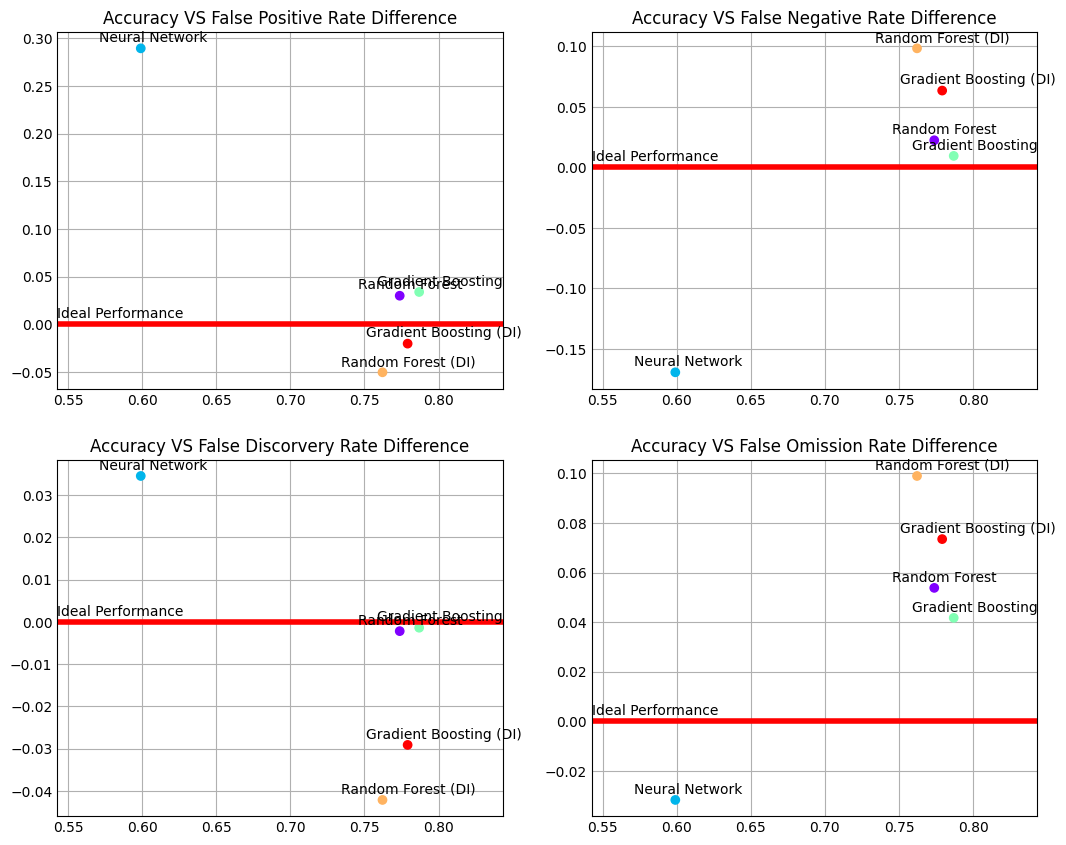

In [26]:
plt.style.use('_mpl-gallery')


# plot
fig, ax = plt.subplots(2,2,figsize=(10,8))

putil.plot_scatter(ax[0][0],result["Accuracy"],result["FPR Difference"],"Accuracy VS False Positive Rate Difference",result.index)
putil.plot_scatter(ax[0][1],result["Accuracy"],result["FNR Difference"],"Accuracy VS False Negative Rate Difference",result.index)
putil.plot_scatter(ax[1][0],result["Accuracy"],result["FDR Difference"],"Accuracy VS False Discorvery Rate Difference",result.index)
putil.plot_scatter(ax[1][1],result["Accuracy"],result["FOR Difference"],"Accuracy VS False Omission Rate Difference",result.index)

plt.show()